# Libraries

In [ ]:
# NLP Libraries: NLTK, Enchant, Spacy, and Regex
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.corpus import words as realwords
import enchant
import spacy
import re
nltk.download('movie_reviews')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('vader_lexicon')

In [85]:
# Model related libraries: Tensorflow, Keras, and Sklearn
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [86]:
# Essentials libraries
import pandas as pd 
import pickle
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from IPython.display import clear_output
pd.set_option('future.no_silent_downcasting', True)
warnings.filterwarnings("ignore", category = DeprecationWarning)

# Variables

In [87]:
# Model variables
vocab_size = 20000
max_len = 100
learning_rate = 0.00075
epochs = 10
batch_size = 32
preproccesing_batch_size = 2000

In [88]:
# Path variables
model_path = '110k.keras'
model_history_path = '110k_history.json'
tokenizer_path = '110k.pickle'

main_dataset_path = '110k_dataset.csv'

rotten_tomatoes_data_path = 'Rotton_Tomatoes_data.csv'
imdb_data_path = 'Stanford_IMDB_data.csv'
sst2_data_path = 'Stanford_SST2_data.csv'

dataset_files = [
    {'variable_names': 'stanford_imdb_train', 'path': 'datasets_raw/Stanford_IMDB_train.csv', 'url': "hf://datasets/stanfordnlp/imdb/plain_text/train-00000-of-00001.parquet"},
    {'variable_names': 'stanford_imdb_validation', 'path': 'datasets_raw/Stanford_IMDB_validation.csv', 'url': "hf://datasets/stanfordnlp/imdb/plain_text/test-00000-of-00001.parquet"},
    {'variable_names': 'stanford_sst2_train', 'path': 'datasets_raw/SST2_train.csv', 'url': "hf://datasets/stanfordnlp/sst2/data/train-00000-of-00001.parquet"},
    {'variable_names': 'stanford_sst2_validation', 'path': 'datasets_raw/SST2_validation.csv', 'url': "hf://datasets/stanfordnlp/sst2/data/validation-00000-of-00001.parquet"},
    {'variable_names': 'rotten_tomatoes_train', 'path': 'datasets_raw/Rotten_Tomatoes__train.csv', 'url': "hf://datasets/cornell-movie-review-data/rotten_tomatoes/train.parquet"},
    {'variable_names': 'rotten_tomatoes_validation', 'path': 'datasets_raw/Rotten_Tomatoes_validation.csv', 'url': "hf://datasets/cornell-movie-review-data/rotten_tomatoes/validation.parquet"},
    {'variable_names': 'rotten_tomatoes_test', 'path': 'datasets_raw/Rotten_Tomatoes_test.csv', 'url': "hf://datasets/cornell-movie-review-data/rotten_tomatoes/test.parquet"}
]

In [89]:
# Text processing variables
html_tag_pattern = re.compile(r'<.*?>')
words_to_keep = {
    'not', 'never', 'no', 'none', 'cannot', 'without', 'neither', 'nor', 'hardly', 'barely', 'rarely', 
    'nothing', 'but', 'although', 'however', 'yet', 'though', 'nonetheless', 'despite', 'still', 'whereas', 
    'even though', 'on the other hand', 'very', 'so', 'really', 'absolutely', 'incredibly', 'especially', 
    'extremely', 'particularly', 'quite', 'definitely', 'indeed', 'nobody', 'nowhere', 'scarcely', 'because', 
    'if', 'unless', 'since', 'thus', 'therefore', 'instead', 'moreover', 'besides', 'furthermore', 'above', 
    'again', 'below', 'down', 'further', 'few', 'just', 'more', 'off', 'need', 'would', 'will', 'through', 
    'under', 'until', 'up', 'while', 'won', 'about', 'after', 'could', 'into', 'now', 'of', 'on', 'once', 
    'only', 'other', 'out', 'over', 'own', 'should', 'some', 'too', 'what', 'why', 'against',
    'can', 'do', 'have', 'how', 'most', 'same', 'such', 'when', 'where', 'which', 'who', 'whom', 'with',
}
stop_words = set(stopwords.words('english')) - words_to_keep
sid = SentimentIntensityAnalyzer()
entity_types = {'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'MONEY', 'NORP', 'PERSON', 'PRODUCT', 'TIME'}
real_words = set(realwords.words())
Word_Dict = enchant.Dict("en_US")
nlp = spacy.load("en_core_web_lg",disable = ['ner', 'parser'])

# Functions

In [90]:
# Function to process text
def process_text(text):
    doc = nlp(re.sub(html_tag_pattern, '', text))
    words = [word.lemma_.lower() for word in doc if word.is_alpha and (word.lemma_.lower() not in stop_words and len(word.lemma_.lower()) > 2) or word.lemma_.lower() in words_to_keep]
    return " ".join(words)

In [91]:
# Function for batch processing texts 
def batch_process_texts(texts):
    processed_texts, counter = [], 0
    for doc in nlp.pipe((re.sub(html_tag_pattern, '', text) for text in texts), batch_size = preproccesing_batch_size):
        words = []
        counter += 1
        if counter % 20 == 0: print(counter)
        for word in doc:
            lemma = word.lemma_.lower()
            if word.is_alpha and (lemma not in stop_words and len(lemma) > 2) or lemma in words_to_keep:
                words.append(lemma)
        processed_texts.append(" ".join(words))
    return processed_texts

In [92]:
# Function for loading datasets
def load_datasets():
    os.makedirs('datasets_raw/', exist_ok = True)
    os.makedirs('datasets_processed/', exist_ok = True)
    for dataset_file in dataset_files:
        if os.path.exists(dataset_file['path']):
            globals()[dataset_file['variable_names']] = pd.read_csv(dataset_file['path'])
            print(f"\x1b[32m {dataset_file['variable_names']} has been loaded! \x1b[0m")
        else:
            print(f"\x1b[31m {dataset_file['variable_names']} is downloading! \x1b[0m")
            globals()[dataset_file['variable_names']] = pd.read_parquet(dataset_file['url'])
            globals()[dataset_file['variable_names']].to_csv(dataset_file['path'], index = False)
            print(f"\x1b[32m {dataset_file['variable_names']} has been loaded! \x1b[0m")
    if os.path.exists('datasets_processed/' + rotten_tomatoes_data_path):
        rotten_tomatoes_data = pd.read_csv('datasets_processed/' + rotten_tomatoes_data_path)
        rotten_tomatoes_data = rotten_tomatoes_data.dropna()
        rotten_tomatoes_data.to_csv("datasets_processed/" + rotten_tomatoes_data_path, index = False)
        print(f"\x1b[32m rotten_tomatoes_data has been loaded! \x1b[0m")
    else:
        print(f"\x1b[31m rotten_tomatoes_data is processing! \x1b[0m")
        rotten_tomatoes_data = pd.concat([rotten_tomatoes_train, rotten_tomatoes_validation, rotten_tomatoes_test])
        rotten_tomatoes_data.columns = ['review', 'rate'] + rotten_tomatoes_data.columns.tolist()[2:]
        rotten_tomatoes_data = rotten_tomatoes_data.drop_duplicates()
        #rotten_tomatoes_data['review'] = rotten_tomatoes_data['review'].map(process_text)
        rotten_tomatoes_data['review'] = batch_process_texts(rotten_tomatoes_data['review'].tolist())
        rotten_tomatoes_data = rotten_tomatoes_data.dropna()
        rotten_tomatoes_data.to_csv("datasets_processed/" + rotten_tomatoes_data_path, index = False)
        print(f"\x1b[32m rotten_tomatoes_data has been loaded! \x1b[0m")
    if os.path.exists('datasets_processed/' + imdb_data_path):
        stanford_imdb_data = pd.read_csv('datasets_processed/' + imdb_data_path)
        stanford_imdb_data = stanford_imdb_data.dropna()
        stanford_imdb_data.to_csv("datasets_processed/" + imdb_data_path, index = False)
        print(f"\x1b[32m stanford_imdb_data has been loaded! \x1b[0m")
    else:
        print(f"\x1b[31m stanford_imdb_data is processing! \x1b[0m")
        stanford_imdb_data = pd.concat([stanford_imdb_train, stanford_imdb_validation])
        stanford_imdb_data.columns = ['review', 'rate'] + stanford_imdb_data.columns.tolist()[2:]
        stanford_imdb_data = stanford_imdb_data.drop_duplicates()
        #stanford_imdb_data['review'] = stanford_imdb_data['review'].map(process_text)
        stanford_imdb_data['review'] = batch_process_texts(stanford_imdb_data['review'].tolist())
        stanford_imdb_data = stanford_imdb_data.dropna()
        stanford_imdb_data.to_csv("datasets_processed/" + imdb_data_path, index = False)
        print(f"\x1b[32m stanford_imdb_data has been loaded! \x1b[0m")
    if os.path.exists('datasets_processed/' + sst2_data_path):
        stanford_sst2_data = pd.read_csv('datasets_processed/' + sst2_data_path)
        stanford_sst2_data = stanford_sst2_data.dropna()
        stanford_sst2_data.to_csv("datasets_processed/" + sst2_data_path, index = False)
        print(f"\x1b[32m sst2_data has been loaded! \x1b[0m")
    else:
        print(f"\x1b[31m sst2_data is processing! \x1b[0m")
        stanford_sst2_data = pd.concat([stanford_sst2_train, stanford_sst2_validation])
        stanford_sst2_data = stanford_sst2_data.drop(columns=['idx'])
        stanford_sst2_data.columns = ['review', 'rate'] + stanford_sst2_data.columns.tolist()[2:]
        stanford_sst2_data = stanford_sst2_data.drop_duplicates()
        #stanford_sst2_data['review'] = stanford_sst2_data['review'].map(process_text)
        stanford_sst2_data['review'] = batch_process_texts(stanford_sst2_data['review'].tolist())
        stanford_sst2_data = stanford_sst2_data.dropna()
        stanford_sst2_data.to_csv("datasets_processed/" + sst2_data_path, index = False)
        print(f"\x1b[32m sst2_data has been loaded! \x1b[0m")
    if os.path.exists('datasets_processed/' + main_dataset_path):
        all_data = pd.read_csv('datasets_processed/' + main_dataset_path)
        all_data = all_data.dropna()
        all_data.to_csv("datasets_processed/" + main_dataset_path, index = False)
        print(f"\x1b[32m {main_dataset_path} has been loaded! \x1b[0m")
    else:
        print(f"\x1b[31m {main_dataset_path} is processing! \x1b[0m")
        all_data = pd.concat([stanford_imdb_data, stanford_sst2_data])
        all_data = all_data.groupby('rate').apply(lambda x: x.sample(all_data["rate"].value_counts().min())).reset_index(drop = True)
        all_data = all_data.dropna()
        all_data.to_csv("datasets_processed/" + main_dataset_path, index = False)
        print(f"\x1b[32m {main_dataset_path} has been loaded! \x1b[0m")
    return all_data, rotten_tomatoes_data

In [93]:
# Function for loading the tokenizer 
def load_tokenizer(dataset):
    if os.path.exists(tokenizer_path):
        with open(tokenizer_path, 'rb') as handle:
            tokenizer = pickle.load(handle)
        print(f"\x1b[32m tokenizer has been loaded! \x1b[0m")
    else:
        print(f"\x1b[31m tokenizer is being created! \x1b[0m")
        tokenizer = Tokenizer(num_words = vocab_size)
        tokenizer.fit_on_texts(dataset['review'])
        word_counts = tokenizer.word_counts
        words = set(word_counts.items())
        words_to_remove, keep, named_entity_words = set(), set(), []
        for word in words:
            scores = sid.polarity_scores(word[0])
            if scores['compound'] != 0 or word[0] in words_to_keep:
                keep.add(word)
            elif not bool(wordnet.synsets(word[0])) and not Word_Dict.check(word[0]) and not word[0] in real_words or word[1] <= 2:
                words_to_remove.add(word) 
        words = list(words - words_to_remove -  keep)
        nlp = spacy.load("en_core_web_lg", disable = ['parser'])
        docs = nlp.pipe((word[0] for word in words), batch_size = preproccesing_batch_size)
        for i, doc in enumerate(docs):
            if any(ent.label_ in entity_types for ent in doc.ents):
                named_entity_words.append(words[i])
        words = set(words) - set(named_entity_words)
        words = words | keep
        words = sorted(words, key = lambda x: x[1], reverse = True)[:vocab_size]
        tokenizer.word_counts = dict(words)
        with open(tokenizer_path, 'wb') as handle:
            pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)
        print(f"\x1b[32m tokenizer has been loaded! \x1b[0m")
    y_train = np.array(dataset['rate'].values)
    x_train = pad_sequences(tokenizer.texts_to_sequences(dataset['review']), maxlen = max_len, padding='post')
    return tokenizer, x_train, y_train

In [94]:
# Function for loading the model
def load_model(tokenizer,x_train, y_train, x_val, y_val):
    if os.path.exists(model_path):
        model = tf.keras.models.load_model(model_path, compile = False, safe_mode = False)
        with open(model_history_path, 'r') as file:
            history = json.load(file)
        print(f"\x1b[32m model has been loaded! \x1b[0m")
    else:
        print(f"\x1b[31m model is being created! \x1b[0m")
        model = Sequential([
            Embedding(input_dim = tokenizer.num_words, output_dim = 128),
            SpatialDropout1D(rate = 0.3),
            Bidirectional(LSTM(units = 128, return_sequences = False)),
            Dropout(0.5),
            Dense(units = 1, activation = 'sigmoid')
        ])
        model.compile(loss = 'binary_crossentropy', optimizer = Nadam(learning_rate = learning_rate), metrics = ['accuracy'])
        history = model.fit(x_train, y_train, epochs = epochs, batch_size = batch_size, validation_data = (x_val, y_val))
        with open(model_history_path, 'w') as file:
            json.dump(history.history, file)
        loss, accuracy = model.evaluate(x_train, y_train)
        print(f"Test Loss: {round(loss,4)}, Test Accuracy: {round(accuracy)}")
        model.summary()
        model.save(model_path)
        history = history.history
        print(f"\x1b[32m model has been loaded! \x1b[0m")
    return model, history

In [95]:
# Function for visualizing the model history
def model_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [96]:
# Model valdiation function
def model_validation(model, tokenizer, dataset):
    print("\x1b[32m model is being validated! \x1b[0m")
    labels = np.array(dataset['rate'].values)
    features = pad_sequences(tokenizer.texts_to_sequences(dataset['review']), maxlen = max_len, padding='post')
    predecited_labels = (model.predict(features) > 0.5).astype("int32")
    print("Accuracy: {:.2f}%".format(accuracy_score(labels, predecited_labels) * 100))
    print("Precision: {:.2f}%".format(precision_score(labels, predecited_labels) * 100))
    print("Recall: {:.2f}%".format(recall_score(labels, predecited_labels) * 100))
    print("F1-Score: {:.2f}%".format(f1_score(labels, predecited_labels) * 100))
    cm = confusion_matrix(labels, predecited_labels)
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'RdYlGn')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    return labels, predecited_labels

In [97]:
# Incorrect predictions visualization function  
def incorrect_predictions(dataset, labels, predecited_labels):
    wrong_indices = np.where(labels != predecited_labels.flatten())[0]
    wrong_predictions = dataset.iloc[wrong_indices].copy()
    print(f"\x1b[31m {len(wrong_predictions)} incorrect predictions! \x1b[0m")
    for review in wrong_predictions['review']:
        print(review)
        print("-" * 80)

In [98]:
# Function for checking non trained words in the input 
def is_word_trained(text,tokenizer):
    for word in text.split(" "):
        if word not in tokenizer.word_counts:
            print(f'\x1b[31m "{word}" is not in our data! \x1b[0m')

In [103]:
# Human validation function
def predict_sentiment(model, tokenizer):
    clear_output(wait = True)
    response = input("\x1b[36m Enter the movie review to recive the sentiment of it: \x1b[0m\n")
    print("\x1b[36m Input: \x1b[0m\n ", response)
    new_review = process_text(response)
    is_word_trained(new_review, tokenizer)
    new_sequence = pad_sequences(tokenizer.texts_to_sequences([new_review]), maxlen = max_len, padding = 'post')
    prediction = model.predict(new_sequence)[0][0]
    print("\x1b[36m Input processed: \x1b[0m\n ", new_review)
    print(f"\x1b[36m The prediction is \x1b[33m {round(prediction*100, 2)}\x1b[36m and the sentiment of the movie review is: \x1b[0m", "\x1b[32mPositive \x1b[0m" if prediction > 0.5 else "\x1b[31mNegative \x1b[0m")

# Program

In [ ]:
# Datasets setup
dataset, validation_dataset = load_datasets()
tokenizer, x_train, y_train = load_tokenizer(dataset)
y_val = np.array(validation_dataset['rate'].values)
x_val = pad_sequences(tokenizer.texts_to_sequences(validation_dataset['review']), maxlen = max_len, padding='post')

 model has been loaded! 


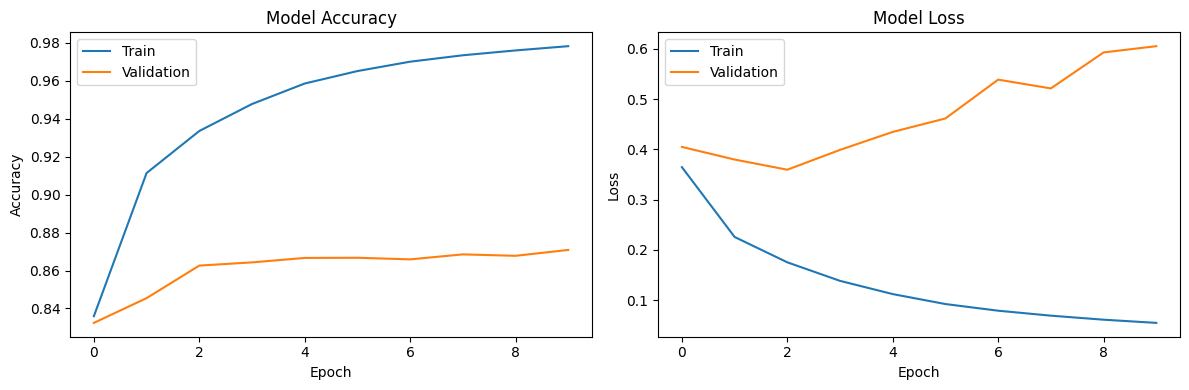

 model is being validated! 
334/334 ━━━━━━━━━━━━━━━━━━━━ 12s 34ms/step
Accuracy: 87.08%
Precision: 87.74%
Recall: 86.21%
F1-Score: 86.97%


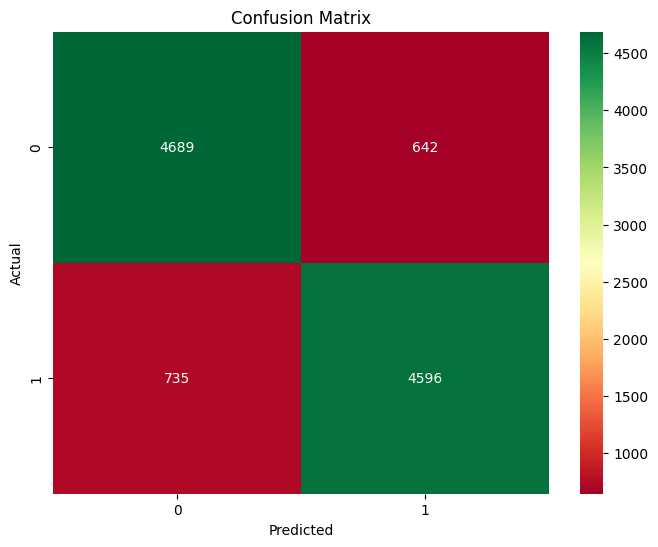

 1377 incorrect predictions! 
effective but too tepid biopic
--------------------------------------------------------------------------------
perhaps no picture ever make have more literally show road hell pave with good intention
--------------------------------------------------------------------------------
steer turn snappy screenplay curl edge so clever want hate but somehow pull off
--------------------------------------------------------------------------------
wendigo why cinema feed through eye heart mind
--------------------------------------------------------------------------------
help lil bow wow tone down pint sized gangsta act play someone who resemble real kid
--------------------------------------------------------------------------------
light cute forgettable
--------------------------------------------------------------------------------
if way effectively teach kid about danger of drug think project like unfortunately rate pay
-------------------------------------

In [107]:
# Model setup
model, history = load_model(tokenizer, x_train, y_train, x_val, y_val)
model_history(history)
validation_labels, validation_predecited_labels = model_validation(model, tokenizer, validation_dataset)
incorrect_predictions(validation_dataset, validation_labels, validation_predecited_labels)

In [ ]:
# Loop
while True:
    predict_sentiment(model, tokenizer)

 Input: 
  
 "" is not in our data! 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
 Input processed: 
  
 The prediction is  48.11 and the sentiment of the movie review is:  Negative 
